In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import re

In [2]:
companies_table = pd.read_csv('/content/companies_tableBDF')
companies_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   id Компании                           410 non-null    object
 1   Зарегистрировано AS в регионе         410 non-null    int64 
 2   Телефон                               410 non-null    object
 3   e-mail                                410 non-null    object
 4   Сегмент рынка (ОКВЭД)                 410 non-null    int64 
 5   Категория бизнеса                     410 non-null    int64 
 6   Предоставляет защиту от DDoS          410 non-null    int64 
 7   Является клиентом                     410 non-null    int64 
 8   Всего договоров AntiDdos              410 non-null    int64 
 9   Всего договоров Circuit               410 non-null    int64 
 10  Всего договоров IP + VPN              410 non-null    int64 
 11  Всего договоров IPL             

Для анализа данных представлен датасет из 410 наблюдений (объекты - компании) по 18 параметрам, 2 из которых - это контакты (не нужны для анализа, удаляем), количество зарегистрированных AS в регионе, сегмент рынка по коду ОКВЭД, категория (размер) бизнеса, продает ли компания услугу защиты от DDoS, является ли нашим клиентом, и 11 параметров - кол-во договоров по указанной услуге

In [3]:
companies_table = companies_table.drop(columns=['Телефон', 'e-mail'], axis=1)

Для начала анализа посмотрим корреляции между всеми признаками - построим график Heatmap для оценки. Прежде всего нас интересует есть ли связь признака "Всего договоров AntiDdos" с другими

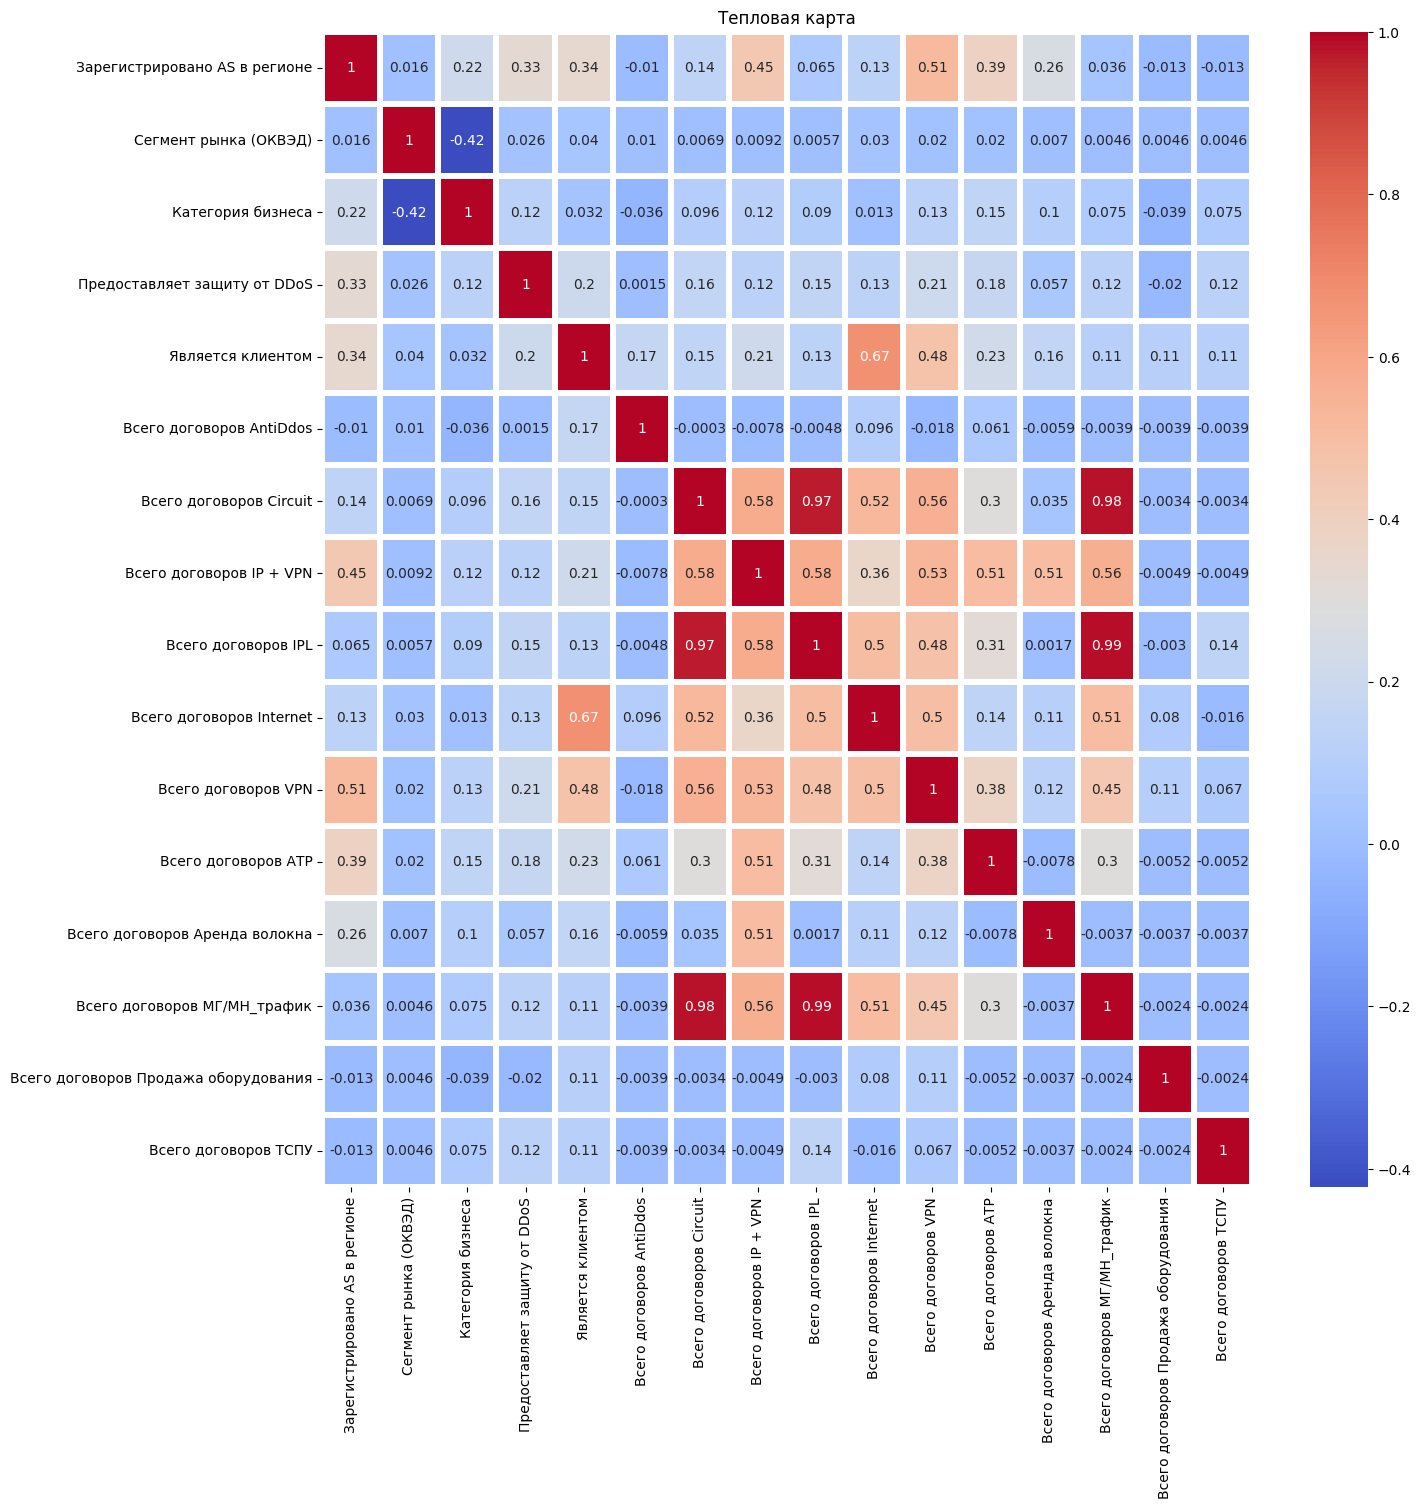

In [7]:
plt.figure(figsize=(15,15))
sns.heatmap(companies_table.corr(numeric_only=True), annot=True, cmap="coolwarm", linewidths=3)
plt.title("Тепловая карта")
plt.show()


In [ ]:
plt.savefig()

Как видим, корреляции с этим признаком крайне малы. Ожидаемо, наблюдаем мультиколлинеарность признаков, связанных с имеющимися с компанией договорами, поэтому для исследования оставим только 1 из них: Всего договоров AntiDdos

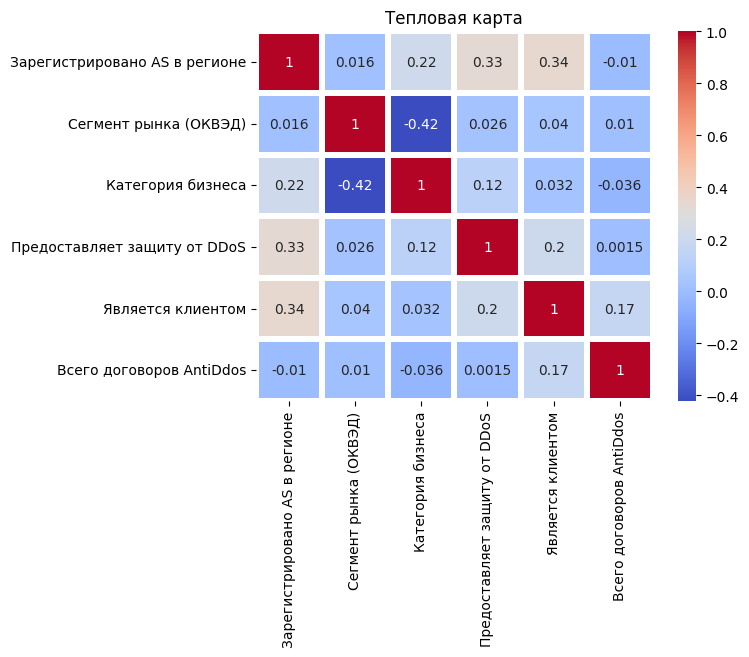

In [ ]:
analysis_data = companies_table[['id Компании', 'Зарегистрировано AS в регионе', 'Сегмент рынка (ОКВЭД)', 'Категория бизнеса', 'Предоставляет защиту от DDoS', 'Является клиентом', 'Всего договоров AntiDdos']]
sns.heatmap(analysis_data.corr(numeric_only=True), annot=True, cmap="coolwarm", linewidths=3)
plt.title("Тепловая карта")
plt.show()

Оставшиеся признаки имеют крайне слабую корреляцию с предоставляемой услугой защиты от ДДоС. При этом наблюдаем корреляции между сегментом рынка и категории бизнеса, которая не входит в задачи анализа, а также есть слабая корреляция между 2 параметрами: предоставляет защиту от DDoS и зарегистрировано AS в регионе (0,33); Является клиентом и зарегистрировано AS в регионе (0,34).

In [ ]:
companies_table['Всего договоров AntiDdos'].value_counts()

,count
Всего договоров AntiDdos,
0,406
1,3
4,1


Всего компания имеет 7 договоров на эту услугу с 4 компаниями - очевидно, признак не репрезентативен для анализа, поэтоому сконцентрируемся на признаке "Предоставляет защиту от DDoS" - такие компании сами предоставляют аналогичную услугу и не могут быть потенциальными клиентами, т.к. являются конкурентами

In [ ]:
companies_table[(companies_table['Всего договоров AntiDdos'] > 0)]

,id Компании,Зарегистрировано AS в регионе,Сегмент рынка (ОКВЭД),Категория бизнеса,Предоставляет защиту от DDoS,Является клиентом,Всего договоров AntiDdos,Всего договоров Circuit,Всего договоров IP + VPN,Всего договоров IPL,Всего договоров Internet,Всего договоров VPN,Всего договоров АТР,Всего договоров Аренда волокна,Всего договоров МГ/МН_трафик,Всего договоров Продажа оборудования,Всего договоров ТСПУ
13,c_id0014,2,63,3,1,1,1,1,0,0,1,0,1,0,0,0,0
19,c_id0020,1,61,2,0,1,1,0,0,0,2,0,0,0,0,0,0
91,c_id0092,1,61,1,0,1,4,0,0,0,2,0,0,0,0,0,0
176,c_id0179,1,62,1,0,1,1,0,0,0,0,0,0,0,0,0,0


Однако, мы не можем однозначно утверждать, что это так - одна компания скорее всего перепродает нашу услугу, т.к. и приобретает услугу у нас и предлагает такую услугу. Тем не менее, мы уже отметили, что статистически признак нерепрезентативен, поэтому перейдем к анализу следующего признака

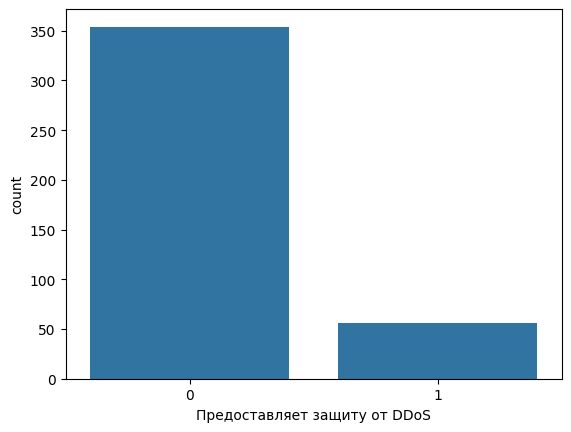

In [ ]:
ddosS = companies_table['Предоставляет защиту от DDoS'].value_counts()
sns.barplot(ddosS)
plt.show()

Подавляющее большинство компаний не предлагает такую услугу, посмотрим, есть ли связь с тем, является ли эта компания нашим клиентом (корреляция 0,2) и с категорией бизнеса (корреляция: 0,12)

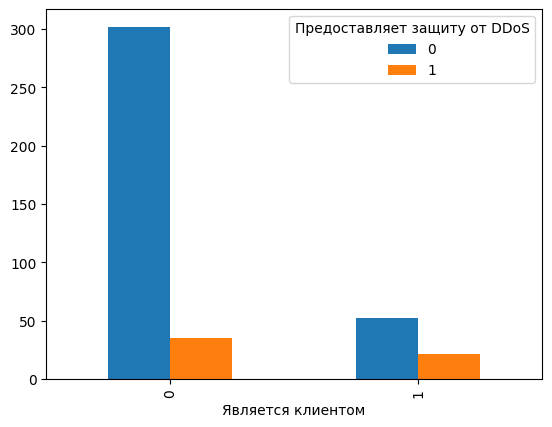

In [ ]:
comp_tbl2 = pd.pivot_table(companies_table, index='Является клиентом', columns='Предоставляет защиту от DDoS' , values='id Компании', aggfunc='count', fill_value=0)
comp_tbl2.plot(kind='bar', )
plt.show()

In [ ]:
pd.pivot_table(companies_table, index='Предоставляет защиту от DDoS', columns='Является клиентом', values='id Компании', aggfunc='count', fill_value=0)

Является клиентом,0,1
Предоставляет защиту от DDoS,,
0,302,52
1,35,21


Разница между тем, является ли компания нашим клиентом или нет, кажется незначительной: Предоставляют услугу 35 НЕ клиентов и **21 клиент**. НЕ предоставляют услугу 302 НЕ клиента и **52 Клиента**


**Гипотеза № 1** является компания клиентом или нет не влияет на то, представляет компания услугу или нет (т.е. потенциальными клиентами могут быть как наши клиенты по другим услугам, так и компании, которые не являются нашими клиентами).

Поскольку значения здесь биноминальные (категориальные), проверим статистическую значимость гипотезы при помощи критерия Хи-квадрата Пирсона (Ho связи между признаками нет:

In [ ]:
h1_data = np.array([
[302, 52], # не предоставляет услугу: [не клиент, клиент]
[35, 21], # предоставляет услугу: [не клиент, клиент]

])

# Проведение теста
chi2, p, dof, expected = stats.chi2_contingency(h1_data)

print(f"Статистика χ²: {chi2:.4f}")
print(f"p-значение: {p:.10f}")
print(f"Степени свободы: {dof}")

# Интерпретация p-значения
if p < 0.001:
  significance = "очень сильная"
elif p < 0.01:
  significance = "сильная"
elif p < 0.05:
  significance = "умеренная"
else:
  significance = "отсутствует"

print(f"Статистическая значимость: {significance}")

Статистика χ²: 15.6677
p-значение: 0.0000755046
Степени свободы: 1
Статистическая значимость: очень сильная


Статистическая значимость очень сильная, значит отвергаем Ho - разница между признаками статистически значима, следовательно опровергаем и нашу Гипотезу № 1: более вероятно, что услуга не будет востребована среди наших клиентов

Посмотрим соотношение предоставления услуги у разных категорий бизнеса

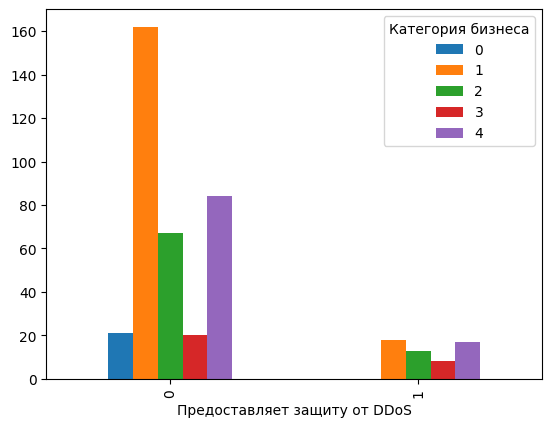

In [ ]:
comp_tbl = pd.pivot_table(companies_table, index='Предоставляет защиту от DDoS', columns='Категория бизнеса' , values='id Компании', aggfunc='count', fill_value=0)
comp_tbl.plot(kind='bar', )
plt.show()

In [ ]:
pd.pivot_table(companies_table, index='Предоставляет защиту от DDoS', columns='Категория бизнеса', values='id Компании', aggfunc='count', fill_value=0)

Категория бизнеса,0,1,2,3,4
Предоставляет защиту от DDoS,,,,,
0,21,162,67,20,84
1,0,18,13,8,17


In [ ]:
micro = 18*180/100
small = 13*80/100
medium = 8*28/100
big = 17*101/100

print(f'Микропредприятия, предоставляющие услугу: {micro}%')
print(f'Малый бизнес, предоставляющий услугу: {small}%')
print(f'Средний бизнес, предоставляющий услугу: {medium}%')
print(f'Крупный бизнес, предоставляющий услугу: {big}%')

Микропредприятия, предоставляющие услугу: 32.4%
Малый бизнес, предоставляющий услугу: 10.4%
Средний бизнес, предоставляющий услугу: 2.24%
Крупный бизнес, предоставляющий услугу: 17.17%


за исключением госсектора услугу предлагают все категории бизнеса,
особенно выделяются микропредприятия и крупный бизнес (более 30% и около 20% соответственно услугу предоставляют). Можем предположить, что категория бизнеса влияет на параметр предоставления услуги.

**Гипотеза № 2**: Категория бизнеса влияет на то, преоставляет ли компания услугу.
Проверим статистическую значимость опять же Хи-квадратом Пирсона (Ho - параметны не связаны)

In [ ]:
h2_data = np.array([
[162, 67, 20, 84], # не предоставляет услугу: [микро, малый, средний, крупный]
[18, 13, 8, 17], # предоставляет услугу: [микро, малый, средний, крупный]

])

# Проведение теста
chi2, p, dof, expected = stats.chi2_contingency(h2_data)

print(f"Статистика χ²: {chi2:.4f}")
print(f"p-значение: {p:.10f}")
print(f"Степени свободы: {dof}")

# Интерпретация p-значения
if p < 0.001:
  significance = "очень сильная"
elif p < 0.01:
  significance = "сильная"
elif p < 0.05:
  significance = "умеренная"
else:
  significance = "отсутствует"

print(f"Статистическая значимость: {significance}")

Статистика χ²: 8.0976
p-значение: 0.0440373550
Степени свободы: 3
Статистическая значимость: умеренная


Статистическая значимость умеренная - скорее категория бизнеса оказывает совсем малое влияние, Ho подтверждаем, Гипотеза № 2 не подтверждена

У нас остается самый сильный признак - связь параметров Предоставления услуги и кол-ва зарегистрированных AS.

**Гипотеза № 3:** если у компании более 1 зарегистрированной AS, то вероятнее она сама будет предоставлять услугу

In [ ]:
companies_as = pd.pivot_table (companies_table, index='Зарегистрировано AS в регионе', columns='Предоставляет защиту от DDoS', values='id Компании', aggfunc='count', fill_value=0, margins=True)
companies_as

Предоставляет защиту от DDoS,0,1,All
Зарегистрировано AS в регионе,,,
1,320,37,357
2,25,8,33
3,5,2,7
4,3,1,4
5,0,4,4
6,1,1,2
7,0,1,1
10,0,1,1
12,0,1,1


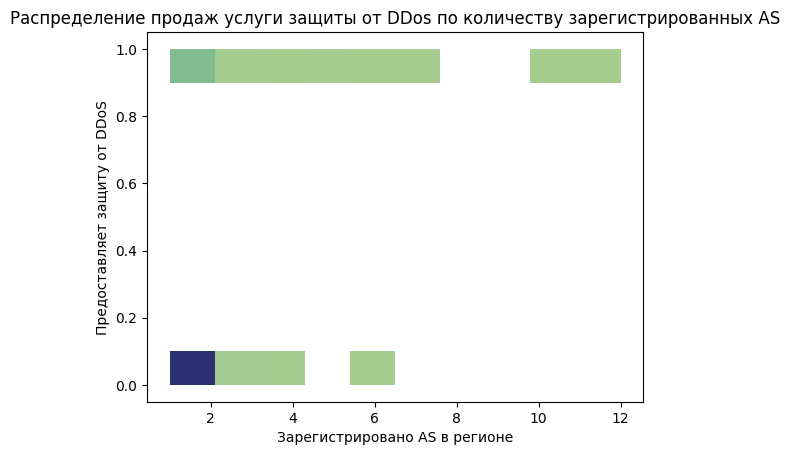

In [ ]:
sns.color_palette("crest", as_cmap=True)
sns.histplot(x=companies_table['Зарегистрировано AS в регионе'], y=companies_table['Предоставляет защиту от DDoS'], data=companies_table, cmap='crest')
plt.title("Распределение продаж услуги защиты от DDos по количеству зарегистрированных AS")
plt.show()

Поскольку в этом случае распределение не явлется нормальным, для проверки статистической значимости применим непараметрический критерий Манна-Уитни (Ho связи между признаками нет)

In [ ]:
without_ddos = companies_table[(companies_table['Предоставляет защиту от DDoS'] == 0)]
with_ddos = companies_table[(companies_table['Предоставляет защиту от DDoS'] == 1)]

U, p = scipy.stats.mannwhitneyu(without_ddos['Зарегистрировано AS в регионе'], with_ddos['Зарегистрировано AS в регионе'], alternative='two-sided')
print(f"Результат применения критерия Манна-Уитни: U={U}, p={p:.7f}")

Результат применения критерия Манна-Уитни: U=7370.0, p=0.0000001


Очень низкое значение \(p\) (гораздо меньше стандартного уровня значимости 0.05) означает, что вероятность случайного совпадения результатов крайне мала, и можно с большой уверенностью отвергнуть нулевую гипотезу об отсутствии различий.

Гипотеза № 3 подтверждается.

Мы смогли подтвердить только 2 гипотезы, очевидно, что для полного анализа рынка нам не хватает параметров. Предполагаем, что нужный нам критерий может появиться после обзвона базы, но как разделить компании между продавцами? Предлагаем прибегнуть к кластеризации (Kmeans), чтобы распределить клиентов по схожим признакам. Поскольку мы предполагаем, что компании предлагающие аналогичную услугу не будут приобретать нашу - удалим их из нашего датафрейма, как и те компании, которые уже приобрели эту услугу у нас. Также оставим еще 2 признака: Сегмент рынка ОКВЭД и Категорию бизнеса для более заметного профилирования компаний

In [ ]:
h3 = companies_table[companies_table['Предоставляет защиту от DDoS'] == 0]
h3 = h3[h3['Всего договоров AntiDdos'] == 0]
h3 = h3[['Сегмент рынка (ОКВЭД)', 'Зарегистрировано AS в регионе', 'Категория бизнеса', 'Является клиентом']]
h3

,Сегмент рынка (ОКВЭД),Зарегистрировано AS в регионе,Категория бизнеса,Является клиентом
3,61,2,1,0
5,61,6,4,1
6,61,3,3,0
7,61,4,1,0
15,59,1,4,1
...,...,...,...,...
405,52,1,3,0
406,46,1,1,0
407,62,1,2,0
408,46,1,2,0


In [ ]:
#X = h3[['Сегмент рынка (ОКВЭД)', 'Категория бизнеса', 'Предоставляет защиту от DDoS', 'Является клиентом']] - 3clusters
X = h3
X = StandardScaler().fit_transform(X)

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5, init='k-means++', n_init='auto', random_state=1, verbose=1)
model.fit(X)

Initialization complete
Iteration 0, inertia 425.249649586291.
Iteration 1, inertia 380.3933226582074.
Iteration 2, inertia 378.85789978728695.
Iteration 3, inertia 378.7402272545068.
Converged at iteration 3: strict convergence.


KMeans(n_clusters=5, random_state=1, verbose=1)

In [ ]:
labels = model.predict(X)
labels

array([1, 3, 3, 3, 2, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 3,
       1, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 0, 2, 1,
       2, 1, 2, 2, 2, 2, 2, 4, 1, 2, 1, 4, 1, 1, 2, 2, 0, 1, 2, 1, 4, 1,
       1, 0, 0, 1, 2, 3, 1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       4, 1, 1, 0, 1, 1, 2, 1, 1, 1, 0, 1, 2, 1, 2, 0, 2, 1, 1, 2, 1, 1,
       4, 2, 2, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1,
       1, 0, 2, 0, 0, 0, 2, 1, 2, 0, 0, 1, 2, 0, 0, 2, 1, 1, 1, 1, 0, 3,
       1, 4, 0, 1, 2, 2, 2, 0, 1, 0, 1, 1, 1, 1, 4, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 4, 1, 1, 4, 1,
       1, 0, 4, 0, 1, 2, 0, 0, 2, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 4,
       0, 1, 0, 4, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 4, 1, 1, 4, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       4, 1, 1, 1, 1, 1, 2, 1, 4, 1, 1, 4, 4, 4, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 0, 1, 1, 1, 1,

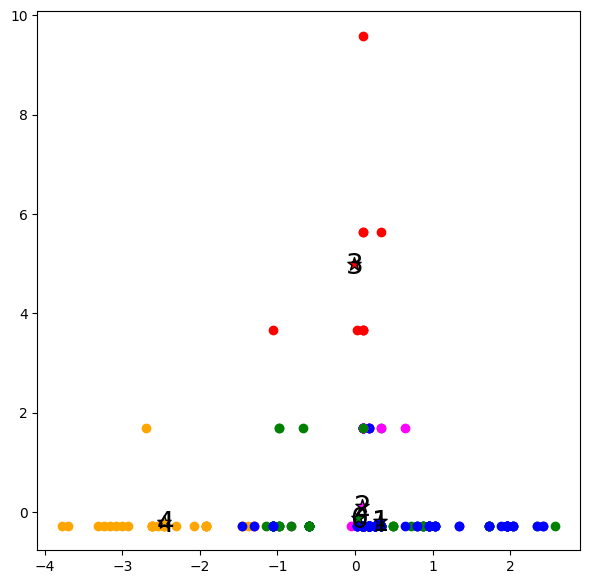

In [ ]:
plt.figure(figsize=(7, 7))
colors=['green', 'blue', 'magenta', 'red', 'orange']
for i in range(len(labels)):
    plt.scatter(X[i, 0], X[i, 1], color=colors[labels[i]])

for i, centr in enumerate(model.cluster_centers_):
    plt.scatter(centr[0], centr[1], marker='*', s=100, c=colors[i], edgecolor='black')
    plt.text(centr[0]-0.1, centr[1]-0.2, f'{i}', fontsize=20);

Поскольку мы используем несколько параметров и часть данных - биноминальные, визуализация выглядит непонятной, для более понятной визуализации используем снижение размерности

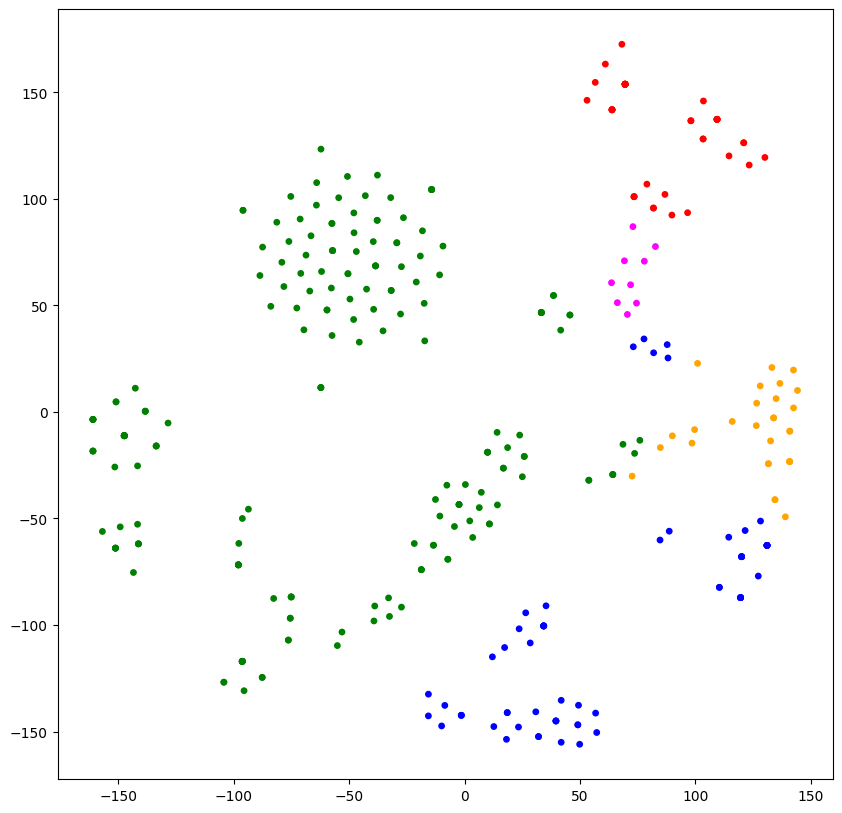

In [ ]:
plt.figure(figsize=(10, 10))
h3['labels'] = labels
tsne_df = TSNE(n_components=2,perplexity=20).fit_transform(X)
h3['tsneX'] = tsne_df[:,0]
h3['tsneY'] = tsne_df[:,1]
def colorer (row,column):
  if row[column] == 1:
    return 'Green'
  elif row [column] == 2:
    return 'Red'
  elif row [column] == 3:
    return 'Magenta'
  elif row [column] == 4:
    return 'Orange'
  else:
    return 'Blue'

h3['color'] = h3.apply(colorer, axis = 1, column = 'labels')

plt.scatter(h3['tsneX'], h3['tsneY'], s=15, c=list(h3['color']))
plt.show()

In [ ]:
cluster = h3[(h3['labels'] == 4)]
cluster['Сегмент рынка (ОКВЭД)'].value_counts()

,count
Сегмент рынка (ОКВЭД),
35,5
26,5
28,3
41,2
21,1
43,1
11,1
22,1
42,1
